In [400]:
from qiskit.transpiler.coupling import CouplingMap
from mirror_gates.pass_managers import Mirage, QiskitLevel3
from transpile_benchy.metrics.gate_counts import (
    DepthMetric,
    TotalMetric,
    TotalSwaps,
)
from qiskit.transpiler import PassManager
import numpy as np
from mirror_gates.logging import transpile_benchy_logger
from mirror_gates.sqiswap_decomposer import SiSwapDecomposePass
from qiskit.transpiler.passmanager import PassManager
from qiskit import Aer, transpile
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    pauli_error,
    depolarizing_error,
    thermal_relaxation_error,
    RelaxationNoisePass,
)
from qiskit.circuit import Delay
from qiskit.transpiler.passes import PadDelay, ASAPSchedule
from qiskit import QuantumCircuit

In [401]:
N = 8
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# coupling_map = CouplingMap.from_grid(4,4)
coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_heavy_hex(5)
# coupling_map.draw()

Loading qft_n8 from QiskitCircuitInterface


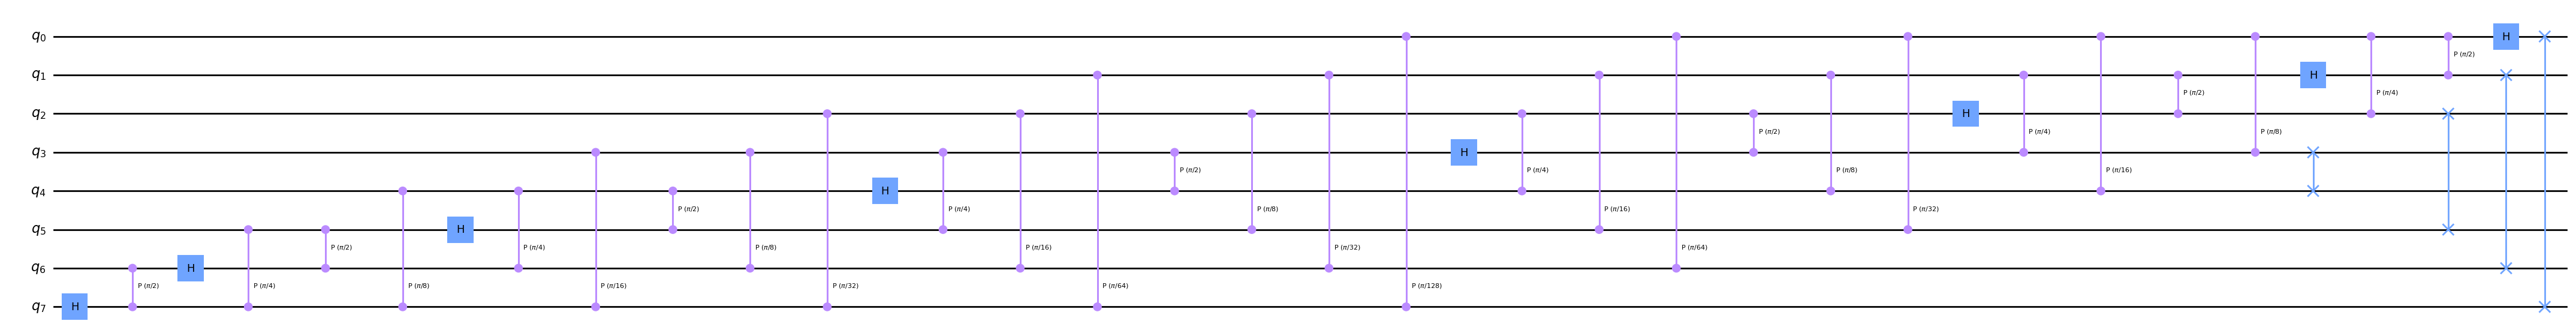

In [402]:
# from transpile_benchy.interfaces.mqt_interface import MQTBench
from transpile_benchy.interfaces.qasm_interface import QASMBench
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary(circuit_list=[])
qc = lib.get_circuit("qft_n8")
qc = qc.decompose()
display(qc.draw("mpl", fold=-1))

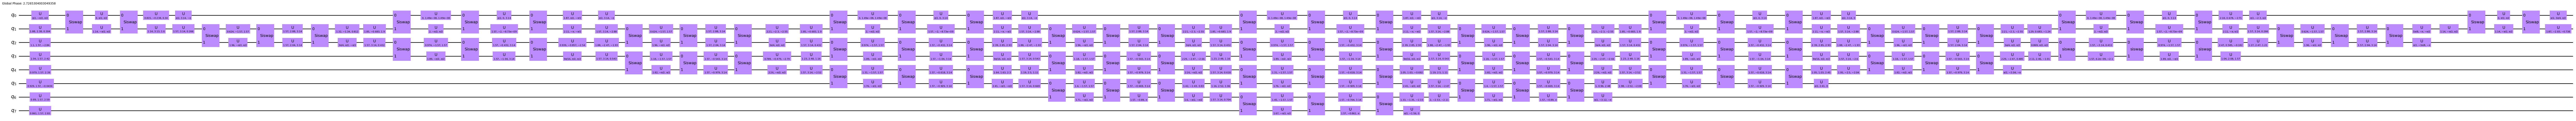

In [403]:
runner = Mirage(
    coupling_map,
    cx_basis=0,
    parallel=0,
    logger=transpile_benchy_logger,
    cost_function="depth",
    # cost_function="basic",
    anneal_routing=True,
    layout_trials=20,
    fb_iters=4,
    # layout_trials=20,
    # fb_iters=4,
    # fixed_aggression=0
    # cost_function="basic",
    use_fast_settings=1,
)

routed = runner.run(qc)
decomposer = PassManager()
decomposer.append(SiSwapDecomposePass())
mirage_output = decomposer.run(routed)
mirage_output.draw("mpl", fold=-1)

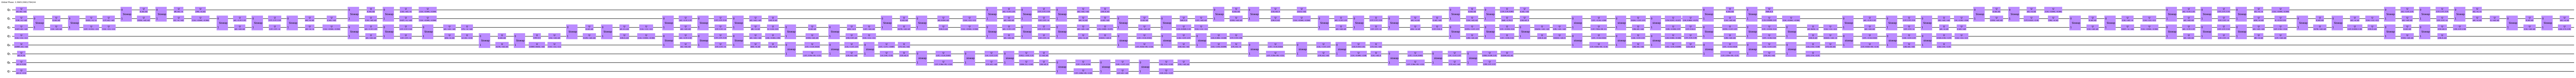

In [404]:
runner = QiskitLevel3(coupling_map, cx_basis=0)
routed = runner.run(qc)
decomposer = PassManager()
decomposer.append(SiSwapDecomposePass())
qiskit_output = decomposer.run(routed)
qiskit_output.draw("mpl", fold=-1)

In [405]:
from mirror_gates.noisy_fidelity import get_noisy_fidelity

print(get_noisy_fidelity(mirage_output, coupling_map))
print(get_noisy_fidelity(qiskit_output, coupling_map))

NoiseModel:
  Basis gates: ['cx', 'rxx', 'ryy', 'u', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'rxx', 'ryy', 'u2', 'u1', 'u3', 'u']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7]
  Specific qubit errors: [('u1', (0,)), ('u1', (1,)), ('u1', (2,)), ('u1', (3,)), ('u1', (4,)), ('u1', (5,)), ('u1', (6,)), ('u1', (7,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u2', (5,)), ('u2', (6,)), ('u2', (7,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('u3', (5,)), ('u3', (6,)), ('u3', (7,)), ('u', (0,)), ('u', (1,)), ('u', (2,)), ('u', (3,)), ('u', (4,)), ('u', (5,)), ('u', (6,)), ('u', (7,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (4, 5)), ('cx', (5, 4)), ('cx', (5, 6)), ('cx', (6, 5)), ('cx', (6, 7)), ('cx', (7, 6)), ('rxx', (0, 1)), ('rxx', (1, 0)), ('rxx', (1, 2)), ('rxx', (2, 1)), ('rxx', (2, 3)), ('rxx', (3, 2)), ('rxx', (3, 4)), ('r

In [406]:
from qiskit.circuit.library import SiSwapGate
from mirror_gates.noisy_fidelity import get_noisy_fidelity

qc = QuantumCircuit(8)
# Hadamard on all qubits
for i in range(8):
    qc.h(i)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)

fid, duration, transp = get_noisy_fidelity(qc, coupling_map)

print(f"Fidelity: {fid:.3f}, Duration: {duration:.3f}")
transp.draw()

NoiseModel:
  Basis gates: ['cx', 'rxx', 'ryy', 'u', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'rxx', 'ryy', 'u2', 'u1', 'u3', 'u']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7]
  Specific qubit errors: [('u1', (0,)), ('u1', (1,)), ('u1', (2,)), ('u1', (3,)), ('u1', (4,)), ('u1', (5,)), ('u1', (6,)), ('u1', (7,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u2', (5,)), ('u2', (6,)), ('u2', (7,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('u3', (5,)), ('u3', (6,)), ('u3', (7,)), ('u', (0,)), ('u', (1,)), ('u', (2,)), ('u', (3,)), ('u', (4,)), ('u', (5,)), ('u', (6,)), ('u', (7,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (4, 5)), ('cx', (5, 4)), ('cx', (5, 6)), ('cx', (6, 5)), ('cx', (6, 7)), ('cx', (7, 6)), ('rxx', (0, 1)), ('rxx', (1, 0)), ('rxx', (1, 2)), ('rxx', (2, 1)), ('rxx', (2, 3)), ('rxx', (3, 2)), ('rxx', (3, 4)), ('r

┌────────────┐                   ┌────────────────┐┌─────────────────┐»
q_0: ┤ U(π/2,0,π) ├────────■──────────┤ Delay(200[dt]) ├┤ Quantum_channel ├»
     ├────────────┤      ┌─┴─┐        └────────────────┘└─────────────────┘»
q_1: ┤ U(π/2,0,π) ├──────┤ X ├───────────────────────────────────■─────────»
     ├────────────┤┌─────┴───┴──────┐┌─────────────────┐       ┌─┴─┐       »
q_2: ┤ U(π/2,0,π) ├┤ Delay(100[dt]) ├┤ Quantum_channel ├───────┤ X ├───────»
     ├────────────┤├────────────────┤├─────────────────┤       └───┘       »
q_3: ┤ U(π/2,0,π) ├┤ Delay(200[dt]) ├┤ Quantum_channel ├───────────────────»
     ├────────────┤├────────────────┤├─────────────────┤                   »
q_4: ┤ U(π/2,0,π) ├┤ Delay(300[dt]) ├┤ Quantum_channel ├───────────────────»
     ├────────────┤├────────────────┤├─────────────────┤                   »
q_5: ┤ U(π/2,0,π) ├┤ Delay(300[dt]) ├┤ Quantum_channel ├───────────────────»
     ├────────────┤├────────────────┤├─────────────────┤                   »
q_6: ┤ U(π/2,0,π) ├┤ Delay(300[dt]) ├┤ Quantum_channel ├───────────────────»
     ├────────────┤├────────────────┤├─────────────────┤                   »
q_7: ┤ U(π/2,0,π) ├┤ Delay(300[dt]) ├┤ Quantum_channel ├───────────────────»
     └────────────┘└────────────────┘└─────────────────┘                   »
«                                           density_matrix 
«q_0: ────────────────────────────────────────────░────────
«     ┌────────────────┐┌─────────────────┐       ░        
«q_1: ┤ Delay(100[dt]) ├┤ Quantum_channel ├───────░────────
«     └────────────────┘└─────────────────┘       ░        
«q_2: ────────■───────────────────────────────────░────────
«           ┌─┴─┐                                 ░        
«q_3: ──────┤ X ├─────────────────────────────────░────────
«           └───┘                                 ░        
«q_4: ────────────────────────────────────────────░────────
«                                                 ░        
«q_5: ────────────────────────────────────────────░────────
«                                                 ░        
«q_6: ────────────────────────────────────────────░────────
«                                                 ░        
«q_7: ────────────────────────────────────────────░────────
«                                                 ░